#  TP 4: 

### 14 avril 2024

### Par Samuel Fortin, Philippe Truchon et Benjamin Trudel

In [1]:
# libs
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from scipy import interpolate
import matplotlib.cm as cm
import time

In [2]:
##### util FILE #####
#####################

def readAngles(filename):

    angles = np.loadtxt(filename)
    nbprj = angles.shape[0]

    # convertir en radians element par element
    angles = (np.pi/180.0)*angles

    return [nbprj, angles]


## lire un sinogramme
def readSinogram(filename):
    
    sino = np.loadtxt(filename)
    nbprj = sino.shape[0]
    nbpix = sino.shape[1]

    return [nbprj, nbpix, sino]

In [3]:
##### geo FILE #####
####################

### paramètres d'acquisition ###

## largeur d'un élément de détecteur (cm)
pixsize = 0.165

## taille du détecteur (nombre d'échantillons)
nbpix = 336

### paramètres de reconstruction ###

## taille de la grille d'image (carrée)
nbvox = 96 # options: 96, 192

## taille du voxel (carré) (cm)
voxsize = 0.4 # option: 0.4, 0.2

## fichiers d'entrée
dataDir = "./data/"
anglesFile = "angles.txt"
# sinogramFile = "sinogram-password.txt"
sinogramFile = "sinogram-patient.txt"

In [4]:
##### CTfilter FILE #####
#########################

def filterSinogram(sino):
    for i in range(sino.shape[0]):
        sino[i] = filterLine(sino[i])
    return sino

## filter une ligne (projection) via FFT
def filterLine(projection):
    fft_signal = np.fft.fftshift(np.fft.fft(projection))  # Transformation de Fourier
    fft_signal_filtered = fft_signal.copy()  # Copie du signal transformé

    length = len(fft_signal_filtered)
    if length%2:
        maxi = np.round(length/2)
        mini = maxi-1
        ramp_filter = np.abs(np.arange(-mini, maxi) / mini)
    else:
        mini = int(length/2)
        maxi = mini+1
        ramp_filter = np.abs(np.arange(-mini, maxi) / mini)
        ramp_filter = np.delete(ramp_filter, mini)

    fft_signal_filtered = fft_signal_filtered*ramp_filter


    return np.fft.ifft(np.fft.ifftshift(fft_signal_filtered)).real

## TP4.1
Supposons, pour simplifier, que le corps humain est fait d'eau pure. Grâce à la base de données XCOM du NIST, trouvez le $\mu$ de l'eau pour des photons de 60 keV, à une masse volumique de 1.0g/$cm^3$. Quelle fraction du signal subsiste après avoir traversé 5cm d'eau; 20 cm d'eau?

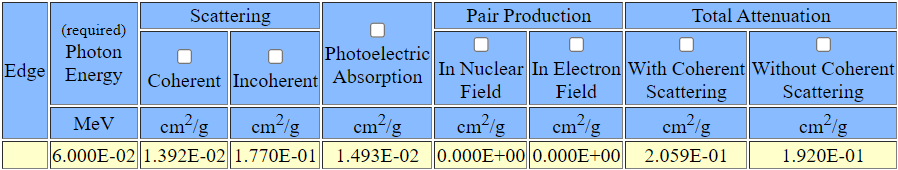

https://physics.nist.gov/PhysRefData/Xcom/html/xcom1.html

Avec la diffusion cohérente: $\mu = 0.2059$ $cm^2/g \cdot 1.0g/cm^3 = 0.2059 cm^{-1}$

Sans diffusion cohérente: $\mu = 0.1920$ $cm^2/g \cdot 1.0g/cm^3 = 0.1920 cm^{-1}$

On utilise donc la loi de Beer-Lambert : $I(x) = I_0 \cdot e^{-\mu \cdot x}$

Pour 5 cm: $I(5) = I_0 \cdot e^{-0.2059 \cdot 5} = 0.3577 I_0$

Pour 20 cm: $I(20) = I_0 \cdot e^{-0.2059 \cdot 20} = 0.0165 I_0$

## TP4.2
En utilisant le code fourni (ou pas), créer une rétroprojection simple, aussi appelée laminogramme, des données de projection fournies. Notez qu'une approche par slicing pourrait accélérer votre algorithme. Votre code utilisera la méthode du plus proche voisn pour déterminer la valeur de projection à utiliser (le rayon passant par la source et le voxel d'intérêt n'aboutit pas nécessairement au centre des pixels du détecteur). Une fois que vous aurez accès au fantôme numérique, comparez-le à la reconstruction. Qualitativement, quelles différences observez-vous entre l'image reconstruite et l'image de référence (fantôme)?

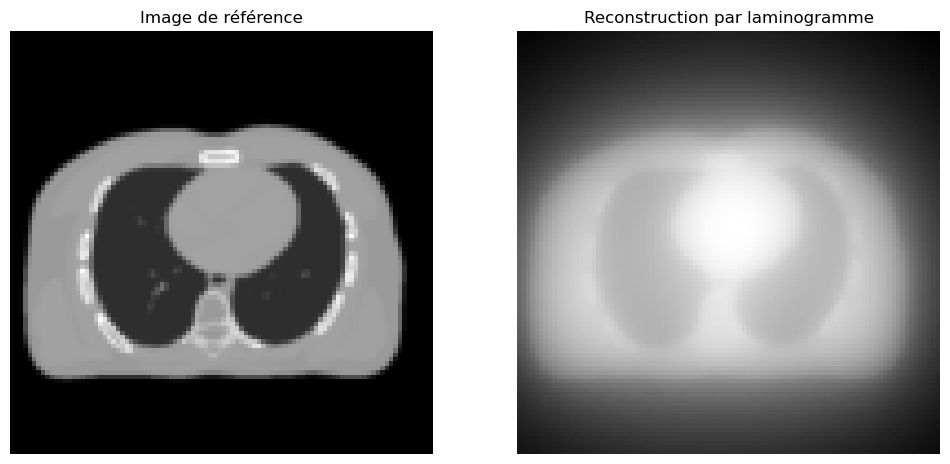

In [5]:
def laminogram(filename):
    # Import
    [nbprj, angles] = readAngles(dataDir+anglesFile)
    [nbprj2, nbpix2, sino] = readSinogram(dataDir+filename)
    image = np.zeros((nbvox, nbvox))

    # Coordonnées
    center = nbvox // 2
    x_coords, y_coords = np.meshgrid(np.arange(nbvox), np.arange(nbvox))
    x_coords_centered = x_coords - center
    y_coords_centered = y_coords - center

    # Reconstruction
    det_pos = x_coords_centered[..., None] * np.cos(angles)*voxsize/pixsize + y_coords_centered[..., None] * np.sin(angles)*voxsize/pixsize
    det_indices = np.round(det_pos + len(sino[0]) / 2).astype(int)
    det_indices = np.clip(det_indices, 0, len(sino[0]) - 1)
    for a in range(len(angles)):
        image += sino[a, det_indices[:,:,a]]

    return np.flip(image,1)

sino_patient = laminogram("sinogram-patient.txt")
sino_ref = mpimg.imread('phantom-thorax-096-smooth.png')

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,12))
ax[0].axis("off")
ax[1].axis("off")
ax[0].set_title("Image de référence")
ax[1].set_title("Reconstruction par laminogramme")
ax[0].imshow(sino_ref, cmap="gray")
ax[1].imshow(sino_patient, cmap="gray")
plt.show()

La plus grande différence est que l'image reconstruite par laminogramme plus floue. En effet, il semble qu'un filtre gaussien a été appliqué sur l'image reconstruite par laminogramme. Cela est causé par la surabondance de basse fréquence dû à la méthode utilisée. 

## TP4.3
En utilisant la librairie numpy.fft, implémentez le filtre passe-haut proposé pour filtrer le sinogramme une projection à la fois. Affichez et sauvegardez l'image du sinogramme filtré. Qualitativement, quelles sont les principales différences entre le sinogramme fourni et filtré?

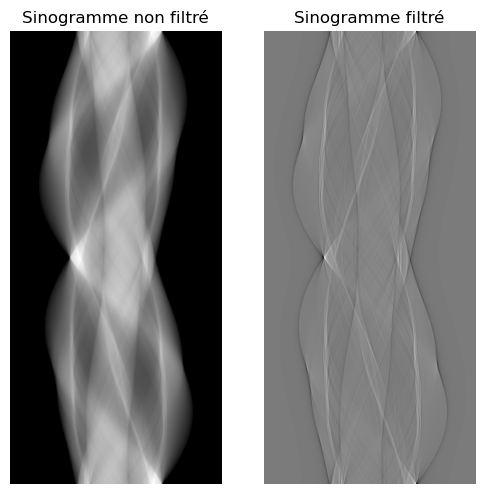

In [6]:
[nbprj, angles] = readAngles(dataDir+anglesFile)
[nbprj2, nbpix2, sinogram] = readSinogram(dataDir+"sinogram-patient.txt")

sinogram_filtre = filterSinogram(sinogram.copy())

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(6,6))
ax[0].axis("off")
ax[1].axis("off")
ax[0].set_title("Sinogramme non filtré")
ax[1].set_title("Sinogramme filtré")
ax[0].imshow(sinogram, cmap="gray")
ax[1].imshow(sinogram_filtre, cmap="gray")
plt.show()

La principale différence est que les basses fréquence sont coupées dans le sinogramme filtré. Ce qui fait que les grosses variations sont disparues et donc seules les variations rapides sont encore présente.

## TP4.4
Ayant en main le sinogramme filtré, effectuez une rétroprojection filtrée, en récupérant idéalement le code précédent du laminogramme. Comparez l'image obtenue avec le fantôme. Quelles différences observez-vous? Où sont situées les erreurs et que diriez-vous de la fréquence spatiale des erreurs?

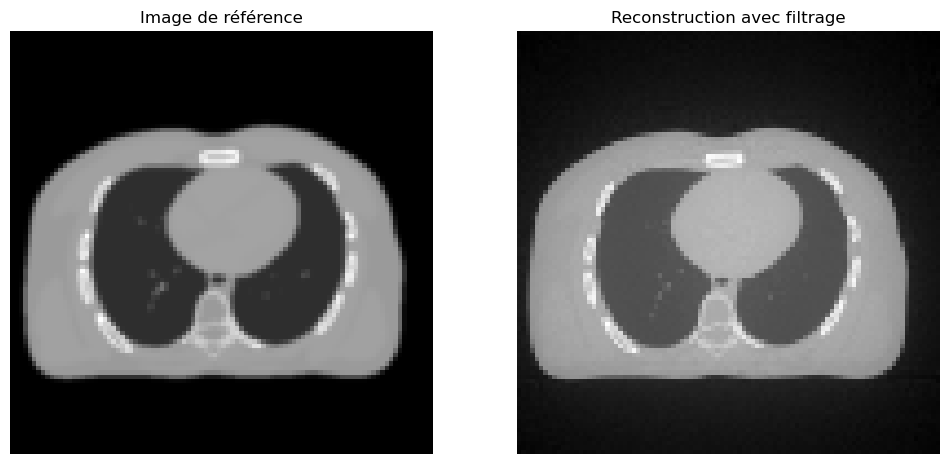

In [7]:
def backproject(filename):
    # Import
    [nbprj, angles] = readAngles(dataDir+anglesFile)
    [nbprj2, nbpix2, sinogram] = readSinogram(dataDir+filename)
    image = np.zeros((nbvox, nbvox))
    
    # Filtre
    sinogram = filterSinogram(sinogram)

    # Coordonnées
    center = nbvox // 2
    x_coords, y_coords = np.meshgrid(np.arange(nbvox), np.arange(nbvox))
    x_coords_centered = x_coords - center
    y_coords_centered = y_coords - center

    # Reconstruction
    det_pos = x_coords_centered[..., None] * np.cos(angles)*voxsize/pixsize + y_coords_centered[..., None] * np.sin(angles)*voxsize/pixsize
    det_indices = np.round(det_pos + len(sinogram[0]) / 2).astype(int)
    det_indices = np.clip(det_indices, 0, len(sinogram[0]) - 1)
    for a in range(len(angles)):
        image += sinogram[a, det_indices[:,:,a]]

    return np.flip(image,1)

sino_patient = backproject("sinogram-patient.txt")
sino_ref = mpimg.imread('phantom-thorax-096-smooth.png')

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,12))
ax[0].axis("off")
ax[1].axis("off")
ax[0].set_title("Image de référence")
ax[1].set_title("Reconstruction avec filtrage")
ax[0].imshow(sino_ref, cmap="gray")
ax[1].imshow(sino_patient, cmap="gray")
plt.show()


Comparez l’image obtenue avec le 
fantôme. Quelles différences observez-vous ? Où sont sitéees les erreurs et que diriez-vvous de la féequence spatiale des erreurs ?

Les principales différences sont au nouveau de l'intensité de certaines régions de l'image obtenue. La résolution et le contour des 2 images sont très smilaire et finalement, l'image obtenue semble avoir un bruit de fond significativement plus élevé.

## TP4.5
Écrivez une nouvelle fonction de reconstruction reconFourierSlice() qui effectue la reconstruction via le théorème de la tranche de Fourier. Il faut effectuer la TF 1D de chaque projection du sinogramme et stocker le nouveau sinogramme transformé. Par échantillonnage du sinogramme, remplissez l'espace de Fourier 2D de l'image à reconstruire. Vous pouvez choisir l'angle approprié par la méthode du plus proche voisin et la position sur le détecteur par interpolation linéaire. Trouvez l'image par $TF_{2D}^{-1}$ et commentez les résultats. Indice : considérez toutes les données comme des nombres complexes avec l'initialisation suivante mymatrix = numpy.zeros((a,b),"complex"), puis, prenez la partie réelle de l'image finale.

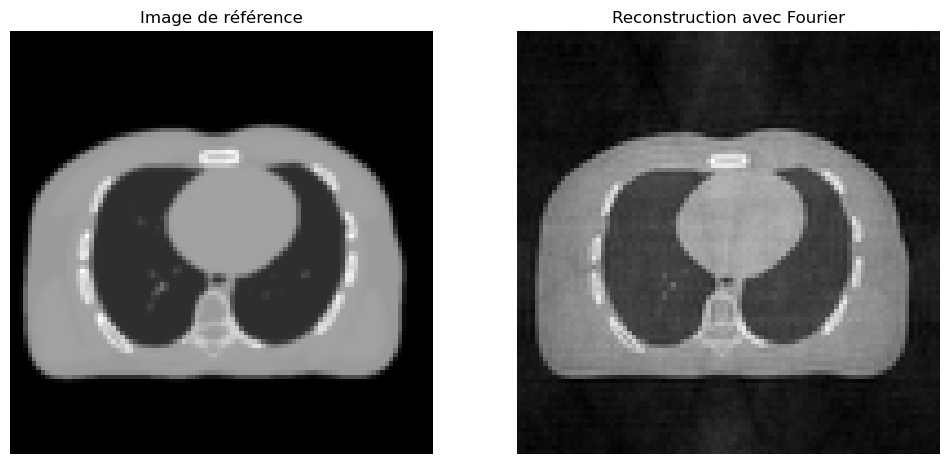

In [8]:
def reconFourierSlice(filename):
    # Import
    [nbprj, angles] = readAngles(dataDir+anglesFile)
    [nbprj2, nbpix2, sinogram] = readSinogram(dataDir+filename)

    # Coordonnées
    xy = np.arange(nbvox//2, -nbvox//2, -1)
    xs, ys = np.meshgrid(xy, -xy.copy())
    z = np.arange(-nbpix//2, nbpix//2, 1)
    xc = np.outer(np.cos(angles), z).ravel()/(voxsize/pixsize-1)
    yc = np.outer(np.sin(angles), z).ravel()/(voxsize/pixsize-1)

    # Reconstruction
    sino_fft = np.fft.fft(np.fft.ifftshift(sinogram))
    sino_fft = np.fft.fftshift(sino_fft)
    fft_TDM = interpolate.griddata((xc, yc),sino_fft.ravel(),(xs, ys),method="linear",fill_value=0,).reshape((nbvox, nbvox))
    TDM = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(fft_TDM))).real
    return TDM

sino_fourier = reconFourierSlice("sinogram-patient.txt")
sino_ref = mpimg.imread('phantom-thorax-096-smooth.png')

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,12))
ax[0].axis("off")
ax[1].axis("off")
ax[0].set_title("Image de référence")
ax[1].set_title("Reconstruction avec Fourier")
ax[0].imshow(sino_ref, cmap="gray")
ax[1].imshow(sino_fourier, cmap="gray")
plt.show()

De manières similaires à la section 4.4 ,les principales différences sont au nouveau de l'intensité de certaines régions de l'image obtenue. La résolution et le contour des 2 images sont très smilaire sauf dans ce cas ci les erreurs sur l'intensité fait perdre quelques petits détails. Finalement, l'image obtenue avec Fourier semble avoir un bruit de fond encore plus élevé que pour la section 4.4.